### DecideNet modelling

In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import json

In [31]:
import scipy.io

scipy.io.savemat('behavioral_data_clean_all.mat', dict(beh=beh))

Load behavioral data.

In [2]:
beh_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
           "data/main_fmri_study/behavioral/behavioral_data_clean_all.npy"
beh_meta_path = beh_path.replace('npy', 'json')

# Load behavioral data
beh = np.load(beh_path)
with open(beh_meta_path, 'r') as f:
    meta = json.loads(f.read())
    
print("Shape of beh array:", beh.shape)
print("Conditions", [(i, cond) for i, cond in enumerate(meta['dim2'])])
print("Columns:", [(i, col) for i, col in enumerate(meta['dim4'])])

n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


Convert data into tensor variables.

In [7]:
actions = (beh[:, 0, :, 4].T + 1) / 2
# actions[actions == 0.5] = 0

# Convert behavioral data into tensor variable
# Shape: (110, 32)
magna = theano.shared(np.asarray(beh[:, 0, :, 2].T, dtype='int32'))
magnb = theano.shared(np.asarray(beh[:, 0, :, 3].T, dtype='int32'))
rewards = theano.shared(np.asarray((beh[:, 0, :, 1].T + 1) / 2, dtype='int32'))
actions = theano.shared(actions)

# is it used???
trials, subjects = np.meshgrid(range(n_trials), range(n_subjects))         
trials = T.as_tensor_variable(trials.T)        
subjects = T.as_tensor_variable(subjects.T)            

In [19]:
def update_vals(rewards,                                                     # task structure (sequences)
                valb,                                                        # values for given trial to update (output-info)
                alpha, n_subjects):                                          # constants (non-sequences)
    """Function updating beliefs about which box will be chosen in the next 
    trial. Used for theano.scan loop."""
    
    current_trial = T.arange(n_subjects)
    PE = rewards - valb[current_trial] 
    valb = T.set_subtensor(
        valb[current_trial],
        valb[current_trial] + alpha * PE
    )
    
    return [valb]

def calculate_softmax(magna, magnb, vala, valb,
                    
                      beta, n_subjects):
    """Description..."""
    
    current_trial = T.arange(n_subjects)
    pa = T.exp(beta * magna[current_trial] * vala[current_trial])
    pb = T.exp(beta * magnb[current_trial] * valb[current_trial])
    
    return [pa, pb]

In [29]:
#################################
### Test update_vals function ###
#################################
alpha = 0.2
valb0 = 0.5 * T.ones([n_subjects])

valb, _ = theano.scan(
    fn=update_vals,
    sequences=[rewards],
    outputs_info=[valb0],
    non_sequences=[alpha, n_subjects]
) 

# Insert first 'agnostic' row on top of val matrix and cut last irrelevant row 
valb_temp = 0.5 * T.ones([n_trials, n_subjects])
valb_temp = T.set_subtensor(
    valb_temp[T.arange(1, n_trials)],
    valb[T.arange(n_trials - 1)]
)
valb = valb_temp
vala = 1 - valb
print(vala.eval())

[[0.5        0.5        0.5        ... 0.5        0.5        0.5       ]
 [0.4        0.6        0.4        ... 0.4        0.6        0.4       ]
 [0.32       0.48       0.32       ... 0.32       0.68       0.32      ]
 ...
 [0.20530905 0.16195455 0.22751234 ... 0.25865975 0.68266335 0.79855635]
 [0.16424724 0.12956364 0.38200987 ... 0.2069278  0.74613068 0.83884508]
 [0.13139779 0.10365091 0.3056079  ... 0.36554224 0.79690454 0.67107607]]


In [ ]:
##################################
### Test update_magns function ###
##################################

In [30]:
beta = 0.2

[pa, pb], _ = theano.scan(
    fn=calculate_softmax,
    sequences=[magna, magnb, vala, valb],
    non_sequences=[beta, n_subjects]
) 

print(pa.eval())

[[ 44.70118449  90.0171313    9.97418245 ...  24.5325302   40.44730436
   49.40244911]
 [  3.32011692  32.45972208   4.5722252  ...  24.5325302   11.02317638
    4.5722252 ]
 [  9.39333129   3.83435027  15.67394845 ...   1.77890855 346.54060572
    2.02182385]
 ...
 [  2.5713258    3.6533201    3.74181785 ...   8.3395555    8.88640621
   24.39127309]
 [  1.80631719   2.96932469  26.71659408 ...   3.32071865 159.76254494
  300.10924396]
 [  2.93721516   2.29150149   5.88570066 ...   2.58676955   4.92246335
  419.76061627]]


In [8]:
with pm.Model() as model:

    #########################################################################
    ### priors ##############################################################
    #########################################################################

    alpha_mu = pm.Beta('alpha_mu', alpha=2, beta=5)
    alpha_sd = pm.HalfNormal('alpha_sd', sd=0.3)
    alpha = pm.Beta('alpha', mu=alpha_mu, sd=alpha_sd, shape=(n_subjects))

#     beta_mu = pm.Bound(pm.Normal, lower=0)('beta_mu', mu=.2, sd=.01)
#     beta_sd = pm.HalfNormal('beta_sd', sd=1)
#     beta = pm.Bound(pm.Normal, lower=0)('beta', mu=beta_mu, sd=beta_sd, shape=(n_subjects))
#     beta_mu = pm.TruncatedNormal('beta_mu', mu=.25, sd=.25, lower=0)
#     beta_sd = pm.HalfNormal('betas_sd', sd=.25)
#     beta = pm.TruncatedNormal('beta', mu=beta_mu, sd=beta_sd, lower=0, shape=(n_subjects))
    
    
    #########################################################################    
    ### generative model ####################################################
    #########################################################################
    
    # Learning part
    valb0 = 0.5 * T.ones([n_subjects])
    valb, _ = theano.scan(
        fn=update_vals,
        sequences=[rewards],
        outputs_info=[valb0],
        non_sequences=[alpha, n_subjects]
    ) 
    # Insert first 'agnostic' row on top of val matrix and cut last irrelevant row 
    valb_shifted = 0.5 * T.ones([n_trials, n_subjects])
    valb_shifted = T.set_subtensor(
        valb_shifted[T.arange(1, n_trials)],
        valb[T.arange(n_trials - 1)]
    )
    valb = valb_shifted
    vala = 1 - valb
    
    # calculate choice probability   
#     [pa, pb], _ = theano.scan(
#         fn=calculate_softmax,
#         sequences=[magna, magnb, vala, valb],
#         non_sequences=[beta, n_subjects]
#     )
#     theta = pb / (pa + pb)
    theta = (valb * magnb) / (vala * magna + valb * magnb) 
    
    
    # Relate values to observed actions
    y = pm.Bernoulli('y', p=theta, observed=actions)     
    
#     theano.printing.Print('alpha:')(alpha)
#     theano.printing.Print('alpha', attrs = [ 'shape' ])(alpha)
    
    #########################################################################
    ### Sampling ############################################################
    #########################################################################

    # MAP (fast, but less good results)
#     map_estimate = pm.find_MAP()
    
    trace = pm.sample(1000)
    # pm.traceplot(trace, ['alpha'])
    # plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, alpha_sd, alpha_mu]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:57<00:00, 104.85draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15da4725c0>,
      dtype=object)

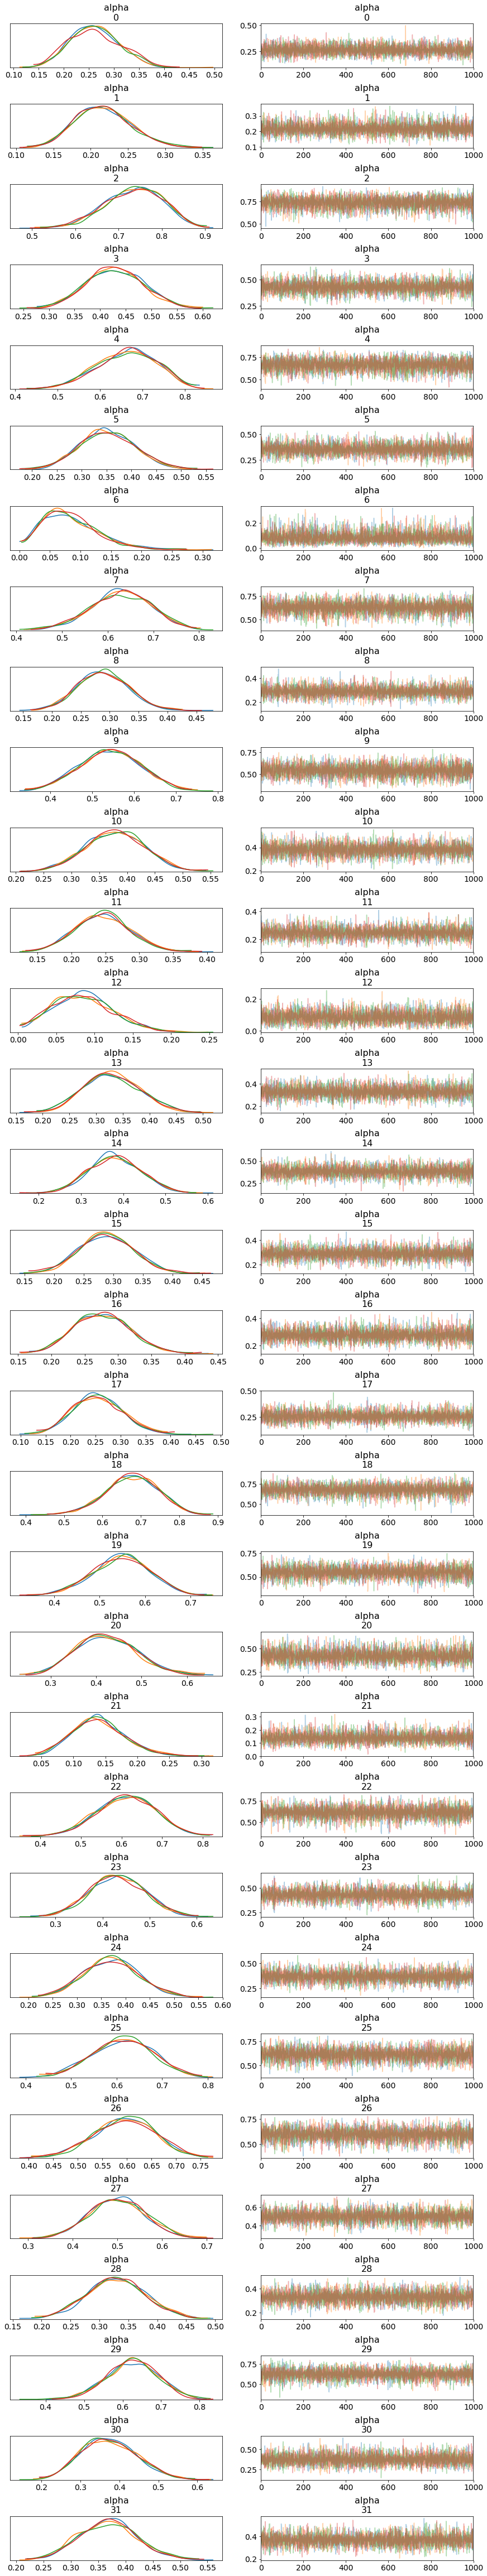

In [9]:
pm.traceplot(trace, ['alpha'])

In [30]:
np.mean(trace['alpha'], axis=0)

array([0.26228057, 0.21657207, 0.73606864, 0.42762624, 0.66321554,
       0.35258763, 0.08427434, 0.62895659, 0.28966843, 0.54308562,
       0.37820038, 0.2455008 , 0.08456836, 0.32836248, 0.37983098,
       0.28728975, 0.27672873, 0.25364293, 0.67742467, 0.54813388,
       0.42496263, 0.14007714, 0.61344656, 0.43100942, 0.36968896,
       0.61311071, 0.59527402, 0.50110867, 0.32851636, 0.62316711,
       0.37531681, 0.3685769 ])